# Advanced Topic Modeling with BERTopic


# **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install bertopic

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Data
1000 ramdom samples per day during 14 days. Then only took the 1st paragraph from each sample.

In [ ]:
import pandas as pd 
import re
from unicodedata import normalize

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Read the dataset from the URL
data = pd.read_csv('/content/drive/Shareddrives/UCM_SHARED/TFM_ESG/HTML Extracts/ESG_TFM-BERTopic_data-20220910193731.csv')

In [ ]:
data.head()

,content_paragraphs,DATE,content_wordcount,content_paragraphcount,DATE_ONLY,1st_parag,2nd_parag,3rd_parag
0,This would cover the entire population when co...,2020-12-30 18:00:00,299,12,2020-12-30,This would cover the entire population when co...,Vaccination centres will now start inviting pa...,Priority groups for immunisation have already ...
1,Canberra will acquire an additional pair of Bo...,2020-12-30 04:00:00,213,6,2020-12-30,Canberra will acquire an additional pair of Bo...,The acquisition is part of the government’s pl...,Source: Greg Waldron/FlightGlobal A Royal Aust...
2,"MAINE, USA — This winter has been brutal so fa...",2020-12-30 22:00:00,449,15,2020-12-30,"MAINE, USA — This winter has been brutal so fa...","Granted, it is still early, but the weather ha...","Now that the warm Christmas storm has passed, ..."
3,In The News is a roundup of stories from The C...,2020-12-30 10:15:00,909,34,2020-12-30,In The News is a roundup of stories from The C...,"Retired Gen. Rick Hillier, who is leading the ...",Hillier said Tuesday that more than half of On...
4,Dolly Parton and her husband Carl Dean.dollypa...,2020-12-30 17:30:00,830,10,2020-12-30,Dolly Parton and her husband Carl Dean.dollypa...,Country music legend Dolly Parton has been mar...,"Dean, a retired businessman who operated an as..."


In [ ]:
# Create a new column containing the length each headline text
data["headline_text_len"] = data["1st_parag"].apply(lambda x : len(x.split()))

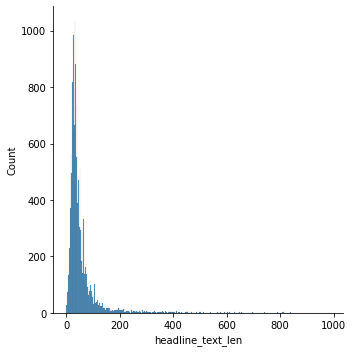

In [ ]:
# Visualize the length distribution 
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.headline_text_len, kde=False)

In [ ]:
print("The longest headline has: {} words".format(data.headline_text_len.max()))

The longest headline has: 986 words


In [ ]:
# Let have a look at some headline text and the longest one
for idx in data.sample(3).index:
    headline = data.iloc[idx]
    print("Headline #{}:".format(idx))
    print("Publication date: {}".format(headline['DATE_ONLY']))
    print("Text: {}\n".format(headline['1st_parag']))

Headline #10624:
Publication date: 2021-01-09
Text: The session’s 90 days will come amid early and mostly behind-the-scenes political jockeying for the 2022 governor’s race, with Republicans already testing campaign themes for their push to oust Kelly. Republican leaders believe they have a mandate to govern after voters preserved the party's legislative supermajorities and elected more conservatives in last year's elections.

Headline #2899:
Publication date: 2021-01-01
Text: WASHINGTON (AP) — Congress has overridden President Donald Trump's veto of a defense policy bill, a first by lawmakers since he took office nearly four years ago.

Headline #10880:
Publication date: 2021-01-09
Text: Pope Francis and Britain's Queen Elizabeth on Saturday became the latest high-profile figures to join the global vaccination campaign against the coronavirus, as the UK reported it had surpassed more than 3 million cases since the pandemic began more than a year ago.



# **Data Preprocessing**

In [ ]:
# Definimos reglas de limpieza antes de lematizar 
def sanitize_word(text):
    """Función realiza una primera limpieza-normalización del texto a traves de expresiones regex"""
    text = re.sub(r'@[\w_]+|#[\w_]+|https?://[\w_./]+', '', text) # Elimina menciones y URL, esto sería más para Tweets pero por si hay alguna mención o URL al ser criticas web   
    text = re.sub('\S*@\S*\s?', '', text) # Elimina correos electronicos
    text = re.sub(r'\((\d+)\)', '', text) #Elimina numeros entre parentesis
    text = re.sub(r'^\d+', '', text) #Elimina numeros sueltos
    text = re.sub(r'\n', '', text) #Elimina saltos de linea
    text = re.sub('\s+', ' ', text) # Elimina espacios en blanco adicionales
    text = re.sub(r'[“”]', '', text) # Elimina caracter citas 
    text = re.sub(r'[()]', '', text) # Elimina parentesis
    text = re.sub('\.', '', text) # Elimina punto
    text = re.sub('\,', '', text) # Elimina coma
    text = re.sub('’s', '', text) # Elimina posesivos
    #text = re.sub(r'-+', '', text) # Quita guiones para unir palabras compuestas (normalizaría algunos casos, exmujer y ex-mujer, todos a exmujer)
    text = re.sub(r'\.{3}', ' ', text) # Reemplaza puntos suspensivos
    # Esta exp regular se ha incluido "a mano" tras ver que era necesaria para algunos ejemplos
    text = re.sub(r"([\.\?])", r"\1 ", text) # Introduce espacio despues de punto e interrogacion
    # -> NFD (Normalization Form Canonical Decomposition) y eliminar diacríticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
                  normalize( "NFD", text), 0, re.I) # Eliminación de diacriticos (acentos y variantes puntuadas de caracteres por su forma simple excepto la 'ñ')
    # -> NFC (Normalization Form Canonical Composition)
    text = normalize( 'NFC', text)

    return text.lower().strip()

In [ ]:
text = 'UK-based pharmaceutical company AstraZeneca received approval for its COVID-19 vaccine on Wednesday (December 30).  The move comes 3 weeks after the UK was the first nation to distribute the Pfizer-BioNTech vaccine.  AstraZeneca’s vaccine was developed in collaboration with Oxford University and is promising to health officials given that it’s cheaper to make and doesn’t require extreme storage temperatures, making rollout simpler.  Prime Minister Boris Johnso n called the news of the vaccine’s approval a “triumph for British science.” “With two vaccines now approved, we will be able to vaccinate a greater number of people who are at highest risk, protecting them from the disease and reducing mortality and hospitalization,” the UK\'s Department of Health said in a statement .'

def clean_text(text, lemmatize=True, stem=True):
  words = text.split() 
  non_stopwords = [word for word in words if word not in stopwords.words('english')]
  clean_text = [sanitize_word(word) for word in non_stopwords] 
  if lemmatize:
    lemmatizer = WordNetLemmatizer()
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
  if stem:
    ps =PorterStemmer()
    clean_text = [ps.stem(word) for word in clean_text]

  return ' '.join(clean_text).strip()

clean_text(text)

"uk-bas pharmaceut compani astrazeneca receiv approv covid-19 vaccin wednesday decemb  the move come  week uk first nation distribut pfizer-biontech vaccin astrazeneca vaccin develop collabor oxford univers promis health offici given it cheaper make doesn’t requir extrem storag temperatur make rollout simpler prime minist bori johnso n call news vaccin approv triumph british scienc with two vaccin approv abl vaccin greater number peopl highest risk protect diseas reduc mortal hospit uk' depart health said statement"

In [ ]:
# Create a new column containing lemmatized clean text
data["clean_1st_parag"] = data["1st_parag"].apply(lambda x : clean_text(x))

# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model. 




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead. 

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model. 


In [ ]:
from bertopic import BERTopic

In [ ]:
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 25, nr_topics=25, n_gram_range=(1, 3))

- Verbose to True: so that the model initiation process does not show messages.  
- paraphrase-MiniLM-L3-v2 is the sentence transformers model with the great trade-off of performance and speed. 
- min_topic_size set to 7 and the default value is 10. The higher the value, the lower is the number of cluster/topics

In [ ]:
topics, probs = model.fit_transform(data['clean_1st_parag'])

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/438 [00:00<?, ?it/s]

2022-09-12 19:42:15,419 - BERTopic - Transformed documents to Embeddings
2022-09-12 19:42:53,162 - BERTopic - Reduced dimensionality
2022-09-12 19:42:53,820 - BERTopic - Clustered reduced embeddings
2022-09-12 19:43:06,799 - BERTopic - Reduced number of topics from 76 to 26


.fit_transform() trains the BERTopic model on the headline dataset   
Also we can see that there are 54 topics overall, but they might not be all relevant. However, we might want to look at those that best represent the collection of headlines using the .get_topic_info() function below. 

## Topic Extraction and Representation. 

In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 26


,Topic,Count,Name
0,-1,8008,-1_the_new_year_vaccin
1,0,1105,0_trump_capitol_presid_donald
2,1,917,1_vaccin_covid_19_covid 19
3,2,518,2_twitter_trump_account_presid
4,3,409,3_air_crash_flight_jakarta
5,4,404,4_coronaviru_vaccin_coronaviru vaccin_case
6,5,251,5_market_global_report_forecast
7,6,247,6_iansliv_ian_delhi_jan ian
8,7,191,7_elect_senat_republican_vote
9,8,177,8_archiv_provid_contain output mani_gener provid


The above table has 3 main columns, providing information about all the 54 topics in descending order of topics size/Count. 
- '**Topic**' is the topic number, a kind of identifier, and the  outliers are labeled as -1. Those are topics that should be ignored because they do not bring any added value. 
- '**Count**' is the number of words in the topic.      
- **Name** is the name given to the topic.

For each topic, we can retrieve the top words and their corresponding c-TF-IDF score. The higher the score, the most relevant the word is in representing the topic.    

In [ ]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('trump', 0.026088017834305654),
 ('capitol', 0.02511864104509777),
 ('presid', 0.019713090768628566),
 ('donald', 0.015100061017970656),
 ('donald trump', 0.015062176919191475),
 ('polic', 0.014734471203611238),
 ('presid donald', 0.013144498299226806),
 ('presid donald trump', 0.013144498299226806),
 ('support', 0.011992962447753703),
 ('washington', 0.011659109994877173)]

From this topic, we observe that all the words are coherent for the underlying topic which seems to be about football ⚽️.


# **Topics Visualization.**   
The topic visualization helps in gaining more insight about each topic. BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, topic hierarchy clustering just to name a few, and our focus will be on those that have been cited. 

## Topic Terms   
The most relevant words of each topic can be visualized in a form of barchart out of the c-TF-IDF score, which is interesting to visually compare topics. 
Below is the corresponding visualization for the topic 6 topics. 

In [ ]:
model.visualize_barchart(top_n_topics=37)

## Intertopic Distance Map.   
For those who are fimiliar with Latent Dirichlet Allocation [LDAvis](https://github.com/cpsievert/LDAvis) library, if not **[here is my article about it](https://towardsdatascience.com/do-you-want-to-cluster-unlabeled-text-data-try-out-topic-modeling-235795ae7cb7)**. This library provides the user with an interactive dashboard showing for each topic the corresponding words and their score. BERTopic does the same with its visualize_topics() function and even go one step further by giving the distance between topics (the lower the most similar), and all of this with a single function **visualize_topics()**

In [ ]:
model.visualize_topics()

## Visualize Topic Hierarchy
As you can see in the Interdistance topic dashboard, some topics are very close. One thing that could come to mind is how can I reduce the number of topics? The good new is that those topics can be hierarchically in order to select the appropriate number of topics. The visualization flavor helps to understand how they relate to one another. 

In [ ]:
model.visualize_hierarchy(top_n_topics=50)

By looking at the first level (level 0) of the dendogram, we can see that topics with the same colors have been grouped together. For instance 
- Topic 7 (health, hospital, mental) & 14 (dies, crash, killed) have been grouped together because of their closeness.  
- Topic 6 (farmers, farm, farmer) & 16 (cattle, sheep, beef) also have be grouped the same way.  
- etc.  
All these information can help the user better understand the reason why the topics have been considered to be similar one to another. 

# **Visualize Topic Similarity**

In [ ]:
model.visualize_heatmap()

# **Search Topics**. 
Once the topic model is trained, we can search for topics that are semantically similar to an input query word/term using the `find_topics` function. 
In our case, we can search for top 3 topics that are related to the word 'politics'

In [ ]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("health care", top_n = 3)

- similar_topics contains the topics index from most similar to least similar.  
- similarity contains the similarity scores in descending order.  


In [ ]:
similar_topics 

[4, 24, 15]

In [ ]:
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('coronaviru', 0.053078716735382496), ('vaccin', 0.02486459610972898), ('coronaviru vaccin', 0.021377873446434787), ('case', 0.015319493150204769), ('health', 0.012064918584576473), ('the', 0.011856161287941005), ('covid', 0.011628132876250268), ('19', 0.01149298958454903), ('covid 19', 0.011402891036027558), ('state', 0.010799749794641565)]
Similarity Score: 0.39133554754099037


We can see that the most similar topic is showing terms 'election', 'trump', 'obama', etc. which are obviously related to politics. 

# **Predict topic**

In [ ]:
text = clean_text(data['content_paragraphs'][0])
preds, probs = model.transform(text)
print(data['content_paragraphs'][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-09-12 19:48:25,900 - BERTopic - Reduced dimensionality
2022-09-12 19:48:25,903 - BERTopic - Predicted clusters


This would cover the entire population when combined with the full order of the Pfizer-BioNTech jab, health secretary Matt Hancock said.

Vaccination centres will now start inviting patients to come and get the jab from next week.

Priority groups for immunisation have already been identified, starting with care home residents, the over-80s, and health and care workers.

Eventually, all over 50s and younger adults with health conditions will be offered a jab in the first phase of the rollout making a total of more than 25 million people.

It is hoped that about two million patients a week could soon be vaccinated with two vaccines now approved.

On Tuesday, 29 December, 53,135 new Covid cases were recorded in the UK, the highest single-day rise since mass testing began as well as 414 more deaths within 28 days of a positive test.

The medicines and healthcare products regulatory agency (MHRA) has authorised two full doses of the Oxford vaccine, with the second dose to be given four to 

In [ ]:
a_topic = freq.iloc[-1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('counti', 0.0509586931024804),
 ('case', 0.04486140401175188),
 ('death', 0.04243589560186167),
 ('covid', 0.03645877371400618),
 ('covid 19', 0.03528374685549018),
 ('19', 0.03522704143206174),
 ('health', 0.02915891402879843),
 ('report', 0.02848685644718607),
 ('total', 0.022591661672552582),
 ('depart', 0.021950269011518236)]

In [ ]:
text = clean_text(data['content_paragraphs'][1])
preds, probs = model.transform(text)
print(data['content_paragraphs'][1])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-09-12 19:48:38,823 - BERTopic - Reduced dimensionality
2022-09-12 19:48:38,830 - BERTopic - Predicted clusters


Canberra will acquire an additional pair of Boeing P-8A Poseidon maritime patrol aircraft, which will boost its fleet of the type to 14 examples.

The acquisition is part of the government’s plan to invest A$270 billion ($205 billion) in defence capability in the 2020s, says defence minister Linda Reynolds.

Source: Greg Waldron/FlightGlobal A Royal Australian Air Force P-8A Poseidon at the Avalon Airshow in February 2019 In addition, sustainment funding has been approved for three Northrop Grumman MQ-4C Triton unmanned air vehicles, which have yet to be delivered.

“Together, the Poseidon and the Triton will provide Australia with one of the most advanced maritime patrol and response capabilities in the world,” says Reynolds.

“The Poseidon is a proven capability that will conduct tasks including anti-submarine warfare, maritime and overland intelligence, surveillance and reconnaissance, and support to search and rescue missions. These additional aircraft will enhance [the] air force’

In [ ]:
preds

[3]

In [ ]:
a_topic = freq.iloc[3]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('twitter', 0.03874373962262776),
 ('trump', 0.03455911809075768),
 ('account', 0.027328739788283027),
 ('presid', 0.022027549221501175),
 ('donald', 0.019754392460365408),
 ('donald trump', 0.019714924900333528),
 ('facebook', 0.01801907524930439),
 ('presid donald trump', 0.015237043527512727),
 ('presid donald', 0.015237043527512727),
 ('social', 0.015197055777890814)]

In [ ]:
candidates = model.find_topics('Health care')
candidates

([3, 16, 11, 15, 1],
 [0.3857783547890454,
  0.3024344353175473,
  0.29406772601784453,
  0.28980289519829416,
  0.260950385020265])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

False

# **Auto nr topics**

In [ ]:
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', nr_topics="auto", n_gram_range = (1, 3))

In [ ]:
headline_topics, _ = model.fit_transform(data['clean_1st_parag'])

Batches:   0%|          | 0/438 [00:00<?, ?it/s]

2022-09-12 19:49:55,787 - BERTopic - Transformed documents to Embeddings
2022-09-12 19:50:12,706 - BERTopic - Reduced dimensionality
2022-09-12 19:50:13,404 - BERTopic - Clustered reduced embeddings
2022-09-12 19:50:26,559 - BERTopic - Reduced number of topics from 195 to 55


In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 42


,Topic,Count,Name
0,-1,5780,-1_the_vaccin_covid_year
1,0,7000,0_the_market_new_trump
2,1,179,1_archiv_provid_path back_machin provid path
3,2,131,2_electr_motor_car_vehicl
4,3,89,3_lockdown_bori johnson_bori_johnson
5,4,72,4_creation content_the marketwatch news_depart...
6,5,65,5_madrid_mexico_spain_central spain
7,6,64,6_stori_view_stori view_view ask support
8,7,54,7_russia_moscow_russian_putin
9,8,33,8_west virginia_virginia_west_lawmak


In [ ]:
model.visualize_barchart(top_n_topics=37)

In [ ]:
model.visualize_topics()

In [ ]:
text = clean_text(data['content_paragraphs'][0])
preds, probs = model.transform(text)
print(preds, probs)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

2022-09-12 19:53:38,310 - BERTopic - Reduced dimensionality
2022-09-12 19:53:38,314 - BERTopic - Predicted clusters


[-1] [0.]


In [ ]:
model.get_topic(-1)

[('the', 0.00704230846216852),
 ('year', 0.004914733844531664),
 ('new', 0.004636288149466891),
 ('said', 0.004411716826306864),
 ('vaccin', 0.004405448046050628),
 ('covid', 0.004203301659034718),
 ('19', 0.003938251386362823),
 ('covid 19', 0.003931663175820578),
 ('trump', 0.0036858401065267402),
 ('one', 0.003441324575341707)]

In [ ]:
candidates = model.find_topics('Health care')
candidates

([52, 43, 42, 46, 28],
 [0.3252038027388858,
  0.232397807204844,
  0.21831663409746094,
  0.21085722290364167,
  0.20827214214679013])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

False

# **Guided topics**

Palabras para cada sector extraidas de 

*   https://relatedwords.org/
*   https://reversedictionary.org/
*   https://www.powerthesaurus.org/
*   https://www.investopedia.com/



In [ ]:
# Topics guided by the companies' sectors related words
industrials = ['industrials', 'machine', 'fabrication', 'industrial design', 'end user', 'flint', 'tool', 'production', 'goods', 'equipment', 'work', 'tool', 'chemical', 'formulation', 'handicraft', 'aircraft', 'furniture', 'automobiles', 'consumer', 'wholesale', 'retailer', 'engineering', 'industry', 'machinery', 'equipment', 'supplies', 'manufacturing', 'construction', 'aerospace', 'railroads', 'gas', 'oil', 'defense'] #, 'general electric', 'honeywell', 'union pacific', 'caterpillar', '3m', 'dow chemical', 'boeing']
health_care = ['health care', 'health', 'medicine', 'treatment', 'nurse', 'healthcare', 'care', 'medical', 'medicare', 'medicaid', 'primary care', 'illness', 'mental health', 'nurse', 'nursing', 'preventive medicine', 'general practitioner', 'welfare', 'patients', 'therapy', 'disease', 'disability', 'chiropractic', 'public health', 'health policy', 'allied health professions', 'pharmacy', 'aid', 'nonmedical', 'attention', 'education', 'patient', 'doctors', 'drugs', 'vaccine', 'medical', 'medical equipment', 'patients', 'biotech', 'pharma', 'doctor'] #, 'novo nordisk', 'vertex ', 'roche', 'pfizer', 'novartis', 'glaxosmithkline', 'astrazeneca', 'medtronic', 'unitedhealth']
info_tech = ['information technology', 'computer', 'hardware', 'programming', 'data', 'information', 'software', 'peripheral', 'statistics', 'machine', 'decision-making', 'computing', 'laptop', 'information system', 'transistor', 'semiconductor', 'microprocessor', 'computer', 'intel', 'digital data', 'bell laboratories', 'ibm', 'integrated circuit', 'jack kilby', 'texas instruments', 'database', 'file', 'device', 'consulting'] #, 'broadcom', 'apple', 'accenture', 'cisco', 'hewlett packard', 'juniper', 'mastercard', 'microsoft', 'nvidia', 'paypal', 'qualcomm']
comm_services = ['communication services', 'web', 'website', 'call service', 'communications', 'communication department', 'communication facilities', 'communication service', 'telecommunications', 'media service', 'reporting services', 'telecom service', 'telecom services', 'telecommunication service', 'telecommunication services', 'telecommunications facilities', 'telecommunications service', 'telecommunications services', 'telecoms services', 'carrier services', 'communication facility', 'communications facility', 'pr department', 'telephone services', 'telco', 'phone services', 'wi-fi', 'internet', 'network', 'email', 'web-based', 'computer network', 'link', 'signal', 'comm', 'wireless', 'channel', 'data', 'transmission', 'mobile', '5g', '4g', '3g', 'optical fiber', 'router']                   
consumer_staples = ['consumer staples', 'daily necessities', 'essential', 'essential products', 'essential services', 'consumer goods', 'consumer articles', 'consumer commodity', 'consumer goods', 'consumer item', 'consumer articles', 'consumption goods', 'consumer product', 'article of consumption', 'commodity product', 'consumable product', 'consumer article', 'consumer durables', 'consumer good', 'consumer item', 'consumer items', 'consumer product', 'consumer products', 'consumption goods', 'consumption items', 'soft goods', 'articles of consumption', 'articles of manufacture', 'clear material', 'consumable goods', 'end products', 'final goods', 'final output', 'final products', 'fine material', 'finished articles', 'finished goods', 'handled material', 'manufactured articles', 'supermarket', 'food', 'beberages', 'essential products', 'household goods', 'hygiene products', 'alcohol', 'tobacco', 'personal products'] #, 'procter', 'pepsico', 'walmart', 'coca-cola', 'mondelez']
consumer_discret = ['consumer discretionary', 'non-essential', 'non-essential products', 'non-essential services', 'wine', 'discretionaries', 'tea', 'inferior goods', 'gourmet', 'watches', 'clothes', 'jewelry', 'whisky', 'arts', 'champagne', 'cognac', 'luxury packaging', 'caviar', 'delicacies', 'holiday', 'durable goods', 'high-end apparel', 'entertainment', 'leisure activities', 'automobile'] #, 'amazon', 'home depot', 'mcdonald', 'nike']
utilities = ['utilities',  'electric utilities', 'gas utilities', 'water utilities', 'producers', 'energy', 'distributors', 'power', 'clean energy', 'electricity', 'natural gas', 'renewable energy', 'turbines', 'solar panel'] #, 'nrg', 'oge']
financials = ['financials', 'investing', 'cash flow', 'capital structure', 'investments', 'stock', 'fiscal', 'asset', 'finance', 'public finance', 'volatility', 'bank', 'corporate finance', 'personal finance', 'treasury', 'portfolio', 'liability', 'insurance', 'retirement', 'equity', 'creditor', 'bond', 'financial engineering', 'financial', 'inventory', 'account', 'debtor', 'stocks', 'statement', 'time value ', 'money', 'rate', 'roi', 'business', 'banknote', 'teller', 'accountancy', 'fund', 'accountant', 'debit', 'ach', 'lender', 'finances', 'loan', 'wall street', 'treasuries', 'london stock ', 'exchange', 'broker', 'moneylender', 'durable good', 'pecuniary', 'bill', 'depositor', 'accountable', 'inflation', 'banker', 'payable', 'hedge', 'payout', 'money', 'bank', 'monetary', 'bankroll', 'dollar', 'currency', 'invoice', 'capital budgeting', 'credit', 'investors', 'sector', 'shares', 'profits', 'markets', 'commodities', 'profitability', 'audit', 'financial services', 'investment companies ', 'insurance companies', 'revenue', 'mortgage'] #, 'jpmorgan ', 'wells fargo', 'citigroup', 'bank of america']
materials = ['materials', 'basic materials', 'processing', 'raw materials', 'mining', 'metal', 'metals ', 'refining', 'chemical', 'forestry', 'products', 'product', 'supply', 'construction', 'raw materialsc', 'oil', 'gold', 'stone', 'mined products', 'ore', 'forestry products', 'forestry', 'lumber', 'chemical producers', 'energy sources', 'containers', 'packaging', 'glass', 'meta', 'miners', 'cardboard', 'natural gas', 'gas', 'crude oil', 'charcoal', 'coal', 'refined', 'refined products', 'gasoline']#, 'exxon', 'chevron', 'schlumberger', 'dupont', 'monsanto', 'vulcan materials', 'steel dynamics']
real_estate = ['real estate''land', 'property', 'realty', 'real property', 'estate', 'realtor', 'asset', 'own', 'investment', 'investor', 'beachfront', 'leasehold', 'occupancy', 'ownership', 'propriety', 'property right', 'owner', 'thingness', 'adverse possession', 'home', 'personal property', 'mortgage', 'condo', 'condominium', 'residential', 'housing', 'leasing', 'foreclosure', 'appraiser', 'rents', 'rental', 'speculator', 'lender', 'builders', 'landlords', 'finca', 'real-estate', 'ownership', 'commercial', 'industrial', 'cooperative', 'duplex', 'townhouse', 'residence', 'apartment', 'station', 'store', 'hotel', 'office', 'facility', 'restaurant', 'shopping center', 'vacant land', 'agricultural land', 'farm', 'ranch', 'timberland', 'government building', 'park', 'house flipping', 'homeownership', 'investment', 'rental', 'lease']#, 'prologis', 'vornado', 'simon property', 'sba']
energy = ['energy', 'solar',  'electric', 'gas', 'producing', 'supplying', 'industry', 'energy industry', 'energy sector', 'exploration', 'development', 'reserves', 'drilling', 'oil', 'gas', 'oil reserves', 'gas reserves', 'oil drilling', 'gas drilling', 'refining', 'fracking', 'power', 'power utility companies', 'power utility', 'renewable energy', 'renewable', 'non-renewable', 'coal', 'transportation', 'petroleum', 'natural gas', 'gasoline', 'diesel fuel', 'heating oil', 'nuclear', 'hydropower', 'biofuels such as ethanol', 'wind power', 'solar power', 'demand', 'power plants', 'refiners', 'crude oil', 'crude'] #, 'exxon', 'chevron', 'peabody']

seed_topic_list = [set([clean_text(word) for word in industrials]),
                   set([clean_text(word) for word in health_care]),
                   set([clean_text(word) for word in info_tech]),
                   set([clean_text(word) for word in comm_services]),
                   set([clean_text(word) for word in consumer_staples]),
                   set([clean_text(word) for word in consumer_discret]),
                   set([clean_text(word) for word in utilities]),
                   set([clean_text(word) for word in financials]),
                   set([clean_text(word) for word in materials]),
                   set([clean_text(word) for word in real_estate]),
                   set([clean_text(word) for word in energy])]              

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cuda")
model = BERTopic(verbose=True, embedding_model=sentence_model, seed_topic_list=seed_topic_list, nr_topics="auto", n_gram_range = (1, 3), min_topic_size=30)
#model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', seed_topic_list=seed_topic_list, n_gram_range = (1, 3), nr_topics=25)

In [ ]:
headline_topics, _ = model.fit_transform(data['clean_1st_parag'])

Batches:   0%|          | 0/438 [00:00<?, ?it/s]

2022-09-12 19:59:22,010 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-09-12 19:59:44,595 - BERTopic - Reduced dimensionality
2022-09-12 19:59:45,354 - BERTopic - Clustered reduced embeddings
2022-09-12 20:00:07,119 - BERTopic - Reduced number of topics from 52 to 40


In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 40


,Topic,Count,Name
0,-1,6468,-1_the_year_new_said
1,0,2327,0_vaccin_covid_19_covid 19
2,1,950,1_the_polic_data_death
3,2,652,2_market_global_report_the
4,3,596,3_trump_twitter_donald_donald trump
5,4,262,4_canada_canadian_vaccin_ottawa
6,5,228,5_jakarta_crash_air_sriwijaya
7,6,205,6_woman_daughter_the_actress
8,7,193,7_facebook_twitter_whatsapp_user
9,8,184,8_new_intel_devic_comput


In [ ]:
model.visualize_topics()

In [ ]:
#text = clean_text(data['content_paragraphs'][0])
text = 'UK-based pharmaceutical company AstraZeneca received approval for its COVID-19 vaccine on Wednesday (December 30).  The move comes 3 weeks after the UK was the first nation to distribute the Pfizer-BioNTech vaccine.  AstraZeneca’s vaccine was developed in collaboration with Oxford University and is promising to health officials given that it’s cheaper to make and doesn’t require extreme storage temperatures, making rollout simpler.  Prime Minister Boris Johnso n called the news of the vaccine’s approval a “triumph for British science.” “With two vaccines now approved, we will be able to vaccinate a greater number of people who are at highest risk, protecting them from the disease and reducing mortality and hospitalization,” the UK\'s Department of Health said in a statement .'

preds, probs = model.transform(text)
print(preds, probs)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-09-12 20:00:54,834 - BERTopic - Reduced dimensionality
2022-09-12 20:00:54,837 - BERTopic - Predicted clusters


[0] [1.]


In [ ]:
model.get_topic(0)

[('vaccin', 0.031758210147556885),
 ('covid', 0.015450708052452742),
 ('19', 0.01484074408441075),
 ('covid 19', 0.014815945251043442),
 ('health', 0.013545753695716303),
 ('19 vaccin', 0.011515263833376727),
 ('covid 19 vaccin', 0.0115012700791011),
 ('coronaviru', 0.009522793346215645),
 ('the', 0.008200589152895876),
 ('first', 0.007537690114681161)]

In [ ]:
candidates = model.find_topics('Health care')
candidates

([0, 14, 2, 11, 17],
 [0.7174093343627999,
  0.6086513705343101,
  0.5945532182910855,
  0.5933731404100482,
  0.5885149019991051])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

True

In [ ]:
candidates = model.find_topics('Financials')
candidates

([20, 36, 2, 16, 24],
 [0.803282286089386,
  0.7903151472081658,
  0.7432287397518175,
  0.720738270512072,
  0.720065846655644])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

False

In [ ]:
candidates = model.find_topics('Information Technology')
candidates

([8, 36, 9, 24, 2],
 [0.7764369440924759,
  0.775543163149394,
  0.7731398476722902,
  0.7659969329528742,
  0.7525943703011767])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

False

In [ ]:
candidates = model.find_topics('Consumer Staples')
candidates

([11, 2, 16, 36, 20],
 [0.7365484734412656,
  0.6977233764602793,
  0.6358747496724195,
  0.628711230943674,
  0.6171174223827391])

In [ ]:
# Check if the predicted topic is within the candidate-topics from the sector keyword
preds[0] in candidates[0]

False

# **Model Serialization & Loading**  
When you are satisfied with your model's result, you can save if for further analysis using the following instructions:     

In [ ]:
%%bash
mkdir './model_dir'

In [ ]:
# Save the model in the previously created folder with the name 'my_best_model'
model.save("/content/drive/Shareddrives/UCM_SHARED/TFM_ESG/BERTopic/BERTopic-1stParagOnly-LemmaClean/TFM_ESG-distilbert-base-nli-mean-tokens")



In [ ]:
# Load the serialized model
my_best_model = BERTopic.load("/content/drive/Shareddrives/UCM_SHARED/TFM_ESG/BERTopic/BERTopic-1stParagOnly-LemmaClean/TFM_ESG-distilbert-base-nli-mean-tokens")
my_best_model

In [ ]:
my_best_model.get_topics()

{-1: [('the', 0.007742478307516968),
  ('year', 0.005551740154520242),
  ('new', 0.005462092707615383),
  ('said', 0.005038118096914891),
  ('trump', 0.004418197119772914),
  ('presid', 0.003979620298803102),
  ('it', 0.0036898764257248294),
  ('one', 0.0036547693006775427),
  ('capitol', 0.003620578829108845),
  ('state', 0.003607851977853805)],
 0: [('vaccin', 0.031758210147556885),
  ('covid', 0.015450708052452742),
  ('19', 0.01484074408441075),
  ('covid 19', 0.014815945251043442),
  ('health', 0.013545753695716303),
  ('19 vaccin', 0.011515263833376727),
  ('covid 19 vaccin', 0.0115012700791011),
  ('coronaviru', 0.009522793346215645),
  ('the', 0.008200589152895876),
  ('first', 0.007537690114681161)],
 1: [('the', 0.007541026728589333),
  ('polic', 0.007412079275760212),
  ('data', 0.006874078155342718),
  ('death', 0.006371461688947658),
  ('year', 0.006364515172150862),
  ('said', 0.0059975091851447474),
  ('covid', 0.005721078908723069),
  ('offic', 0.005416584279095949),
  

# **Conclusion**
Now, you know how to use BERTopic for topic modeling. The results are very encouraging, and do not hesitate to give it a try on your business case. However, it is important to note that the results of BERTopic are not consistent between runs, this is due to the stochastic nature of UMAP used for dimensionality reduction. So, using the random_state parameter in UMAP the any stochastic behavior. 

# **Additional Ressources**   
[BERTopic Algorithm](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)    
 [BERTopic FAQ](https://maartengr.github.io/BERTopic/faq.html#:~:text=Why%20are%20the%20results%20not%20consistent%20between%20runs%3F,-%C2%B6&text=Due%20to%20the%20stochastic%20nature,topics%20that%20suit%20you%20best.)  
 [BERTopic Github](https://github.com/MaartenGr/BERTopic)

Referencias

https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212

https://www.arxiv-vanity.com/papers/2203.05794/